# Plasticity Simulation Example

This notebook demonstrates how to simulate plasticity in single-cell data using the PLASTRO package. We'll walk through different types of plasticity simulations including random walk plasticity and cluster-based plasticity switches.

## Overview

The PLASTRO package provides tools to:
1. Generate simulated single-cell phenotypic data
2. Simulate lineage tracing with CRISPR mutations
3. Introduce different types of cellular plasticity
4. Analyze the effects of plasticity on phenotypic and lineage relationships

In [40]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anndata import AnnData
import scanpy as sc

# Import PLASTRO package
import plastro

In [41]:
# Set up plotting parameters
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')
sc.settings.verbosity = 1  # verbosity level

## 1. Generate Simulated Single-Cell Data

### 1a. Phenotypic data
First, we'll create simulated single-cell data with a branching structure that mimics cellular differentiation trajectories.

In [42]:
# Parameters for simulation
n_leaves = 8  # Number of terminal cell types
sample_res = 50  # Number of cells per branch
n_dim = 20  # Number of phenotypic dimensions

# Create results directory
results_dir = 'plasticity_example_results'
os.makedirs(results_dir, exist_ok=True)

print(f"Generating simulated data with {n_leaves} cell types, {sample_res} cells per type, {n_dim} dimensions")

Generating simulated data with 8 cell types, 50 cells per type, 20 dimensions


In [43]:
# Generate the branching structure and simulated data
# Use PLASTRO's built-in simulation functions

print("Using PLASTRO simulation functions...")

# Create a random binary tree structure
sample_structure = plastro.create_random_binary_tree(n_leaves, sample_res)
full_simulated_ad = plastro.generate_ad(sample_structure, n_dim)

print(f"Created simulated data with {full_simulated_ad.n_obs} cells and {full_simulated_ad.n_vars} features")
print(f"Number of branches: {len(full_simulated_ad.obs['branch'].unique())}")
print(f"Number of leiden clusters: {len(full_simulated_ad.obs['leiden'].unique())}")

Using PLASTRO simulation functions...
Created simulated data with 3850 cells and 20 features
Number of branches: 15
Number of leiden clusters: 16


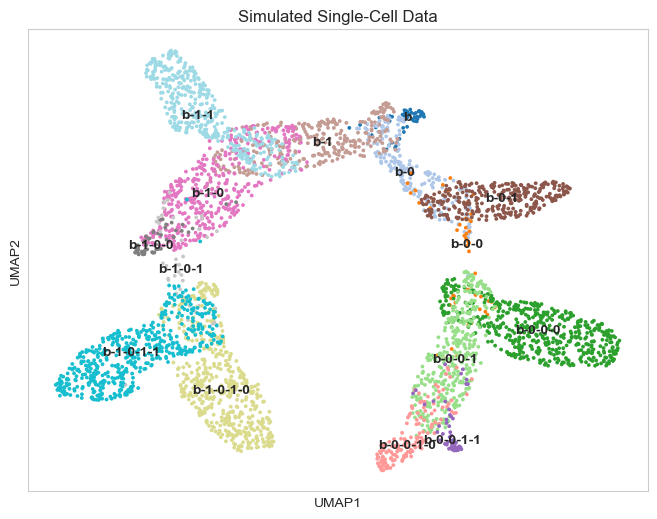

In [44]:
# Visualize the simulated data
sc.pl.umap(full_simulated_ad, color='branch', legend_loc='on data', 
           title='Simulated Single-Cell Data', size=30)

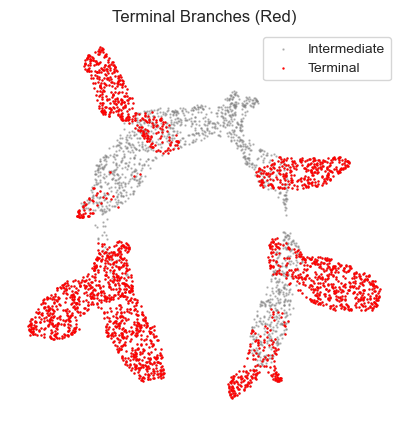

Selected 8 terminal branches:
  b-0-0-0: 500 cells
  b-0-0-1-0: 150 cells
  b-0-0-1-1: 50 cells
  b-0-1: 300 cells
  b-1-0-0: 50 cells
  b-1-0-1-0: 500 cells
  b-1-0-1-1: 500 cells
  b-1-1: 400 cells
Keeping 2450 cells from terminal branches


In [45]:
ad = plastro.subset_to_terminal_branches(full_simulated_ad, show_plots=True)
# TODO: Optionally you can sample based on pseudotime (preferentially sample terminal states with some temperature control)
print('Keeping {} cells from terminal branches'.format(ad.n_obs))

### 1b. Lineage Tracing
Next, we introduce lineage tracing data onto the branching process using the Cassiopeia CRISPR/Cas9 simulator.

In [46]:
cass_tree = plastro.simulate_lineage_tracing(full_simulated_ad, ad, 'X_dc', save_to=results_dir)

Starting neighbor-joining with 2451 taxa using scikit-bio
Tree rooted with outgroup: Cell_5
Neighbor-joining completed successfully
Saved tree to plasticity_example_results/simulated_tree.nwk


In [47]:
# Save the character matrix with CRISPR mutations
character_matrix = cass_tree.character_matrix
assert set(character_matrix.index) == set(ad.obs_names), 'Character matrix and terminal ad obs_names do not match'

# Save the character matrix
character_matrix.to_csv(os.path.join(results_dir, 'character_matrix.csv'))

In [51]:
from scipy.spatial.distance import pdist, squareform
# Replace -1 with nan
character_matrix = character_matrix.replace(-1, np.nan)
# Use Hamming distance to roughly approximate phylogenetic distance
phylogenetic_distances = pdist(character_matrix.values, metric='hamming')
phylogenetic_distances = squareform(phylogenetic_distances)
phylogenetic_distances = pd.DataFrame(phylogenetic_distances, index=character_matrix.index, columns=character_matrix.index)


## 2. Random Walk Plasticity Simulation

Random walk plasticity simulates cells transitioning through phenotypic space via random walks on a connectivity graph. Cells can move from their original phenotype to distant phenotypes through intermediate states.

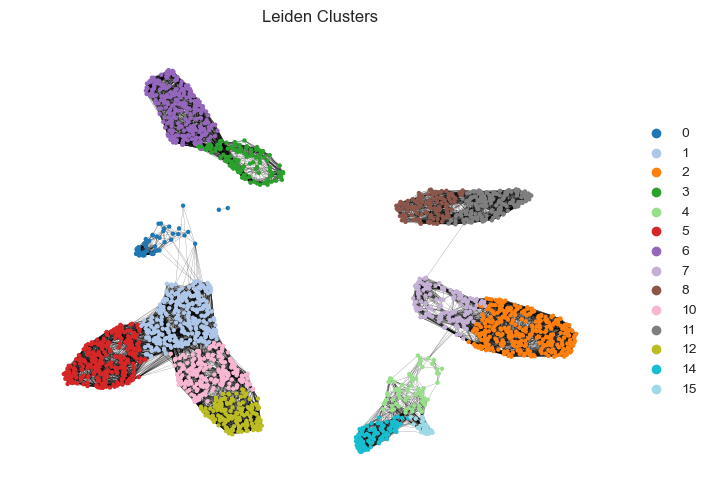

In [52]:
# Let's visualize the cell states/ leiden clusters of the cells in our final dataset
sc.pl.umap(ad, color='leiden', title='Leiden Clusters', size=40,
            frameon=False, 
           edges=True, 
           edges_color='black')

We will choose a leiden cluster to be "plastic". We will choose a specific number of cells from this cluster to undergo random walks of a specified length. 
This random walk will allow us to model potential de-differentiation and trans-differentiation processes, as the cell will take on the phenotype of the cell at the end of its random walk on the phenotypic manifold

Selected 81 plastic cells from leiden cluster 6
Selected 57 plastic cells from leiden cluster 5


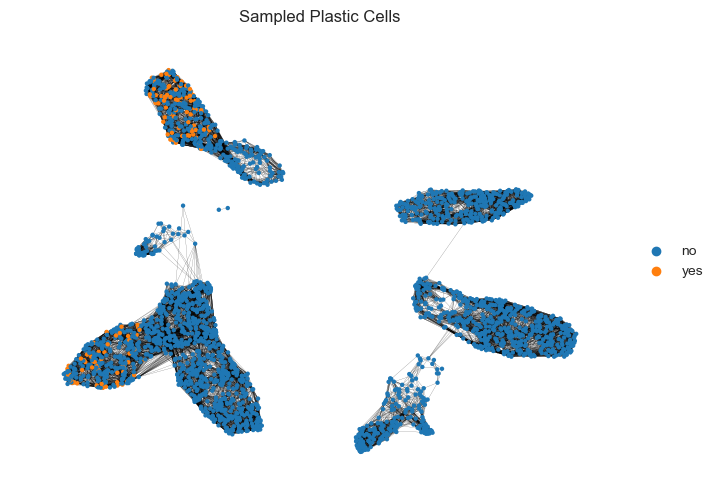

Leiden cluster 6: 81 plastic cells will perform random walks of length 500
Random walks - T=0.06s
Leiden cluster 5: 57 plastic cells will perform random walks of length 1000
Random walks - T=0.11s


/Users/spersad/.local/share/mamba/envs/plastro_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/spersad/Documents/PLASTRO/plastro/plasticity.py:128: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  final_ad.obs['change_in_phenotype'] = change_distances


In [53]:
# Optionally, we can do this for more than one cluster
proportion_plastic = {6: 0.3, 5: 0.2}
plastic_cells = {}
for lc in proportion_plastic.keys():
    cluster_cells = ad.obs_names[ad.obs['leiden'] == str(lc)].to_list()
    n_plastic = int(len(cluster_cells) * proportion_plastic.get(lc, 0))
    selected_cells = np.random.choice(cluster_cells, n_plastic, replace=False).tolist()
    plastic_cells[lc] = selected_cells
    print(f"Selected {n_plastic} plastic cells from leiden cluster {lc}")

all_plastic_cells_random_walk = [cell for cells in plastic_cells.values() for cell in cells]
ad.obs['Will Change Phenotype'] = ['yes' if cell in all_plastic_cells_random_walk else 'no' for cell in ad.obs_names]
sc.pl.umap(ad, color=['Will Change Phenotype'], title=['Sampled Plastic Cells'], size=40,
            frameon=False, 
           edges=True, 
           edges_color='black')

plt.show()

# We will choose the random walk to be of length 500 and 1000 for the two clusters
walk_lengths = {6: 500, 5: 1000}
plastic_walk_ad = plastro.random_walk_plasticity(full_simulated_ad, ad, plastic_cells, walk_lengths)



We can now visualize the updated phenotypes of cells that performed random walks. We may observe de-differentiation, as they return to more ancestral states, as well as trans-differentiation, where they change phenotype to match those in other terminal cell states.

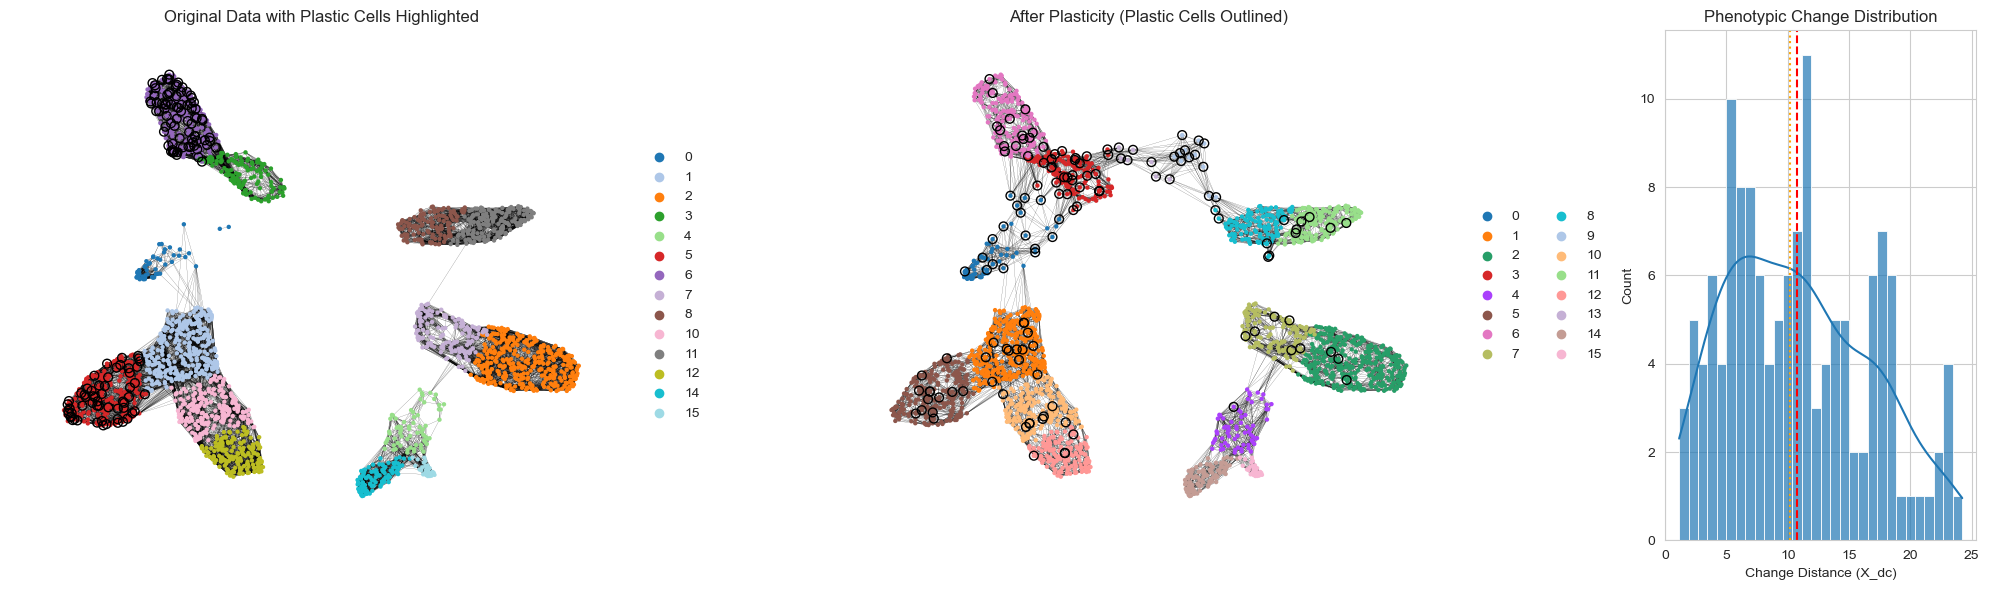

In [54]:
sc.pp.neighbors(plastic_walk_ad)
plastro.plot_change_in_phenotype(ad, plastic_walk_ad, all_plastic_cells_random_walk, show_plots=True, save_to=os.path.join(results_dir, 'random_walk_phenotype_change.png'))


### 2b. Visualizing Individual Random Walks

Let's examine specific examples of random walks to understand how cells transition through phenotypic space.

Performing random walk from cell: Cell_10
Walk length: 200
Random walks - T=0.03s
Walk ended at cell: Cell_3787
Phenotypic change: 14


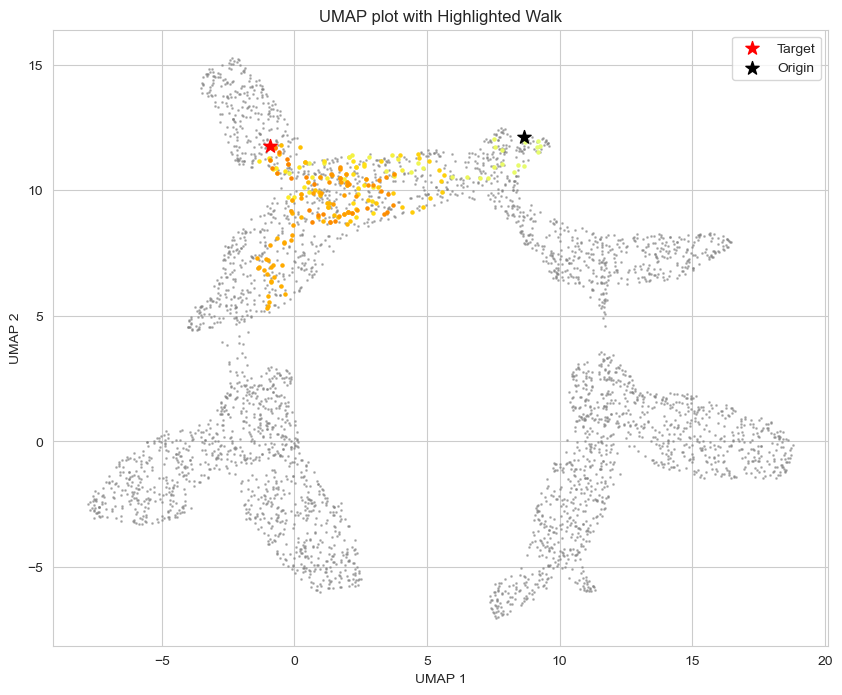

In [55]:
# Perform a single random walk for visualization
target_cells = [full_simulated_ad.obs_names[10]]  # Choose a specific cell
walk_length = 200

print(f"Performing random walk from cell: {target_cells[0]}")
print(f"Walk length: {walk_length}")

# Perform the walk
targets, change_in_phenotype, walk_indices = plastro.perform_random_walk(
    full_simulated_ad, 
    plastic_cells=target_cells, 
    walk_length=walk_length
)

print(f"Walk ended at cell: {targets.loc[target_cells[0], 'target']}")
print(f"Phenotypic change: {change_in_phenotype.loc[target_cells[0], 'change_in_phenotype']}")

# Visualize the random walk path
plastro.visualize_walk(full_simulated_ad, walk_indices[0], show_plots=True)
plt.show()


## 3. Leiden Cluster Switch Plasticity

This type of plasticity simulates discrete switches between phenotypic clusters. Cells from an origin cluster directly adopt the phenotype of cells from target clusters, mimicking a trans-differentiation process (or de-differentiation if we select transitions to ancestral states). First we must decide which clusters we want to change to which clusters. 

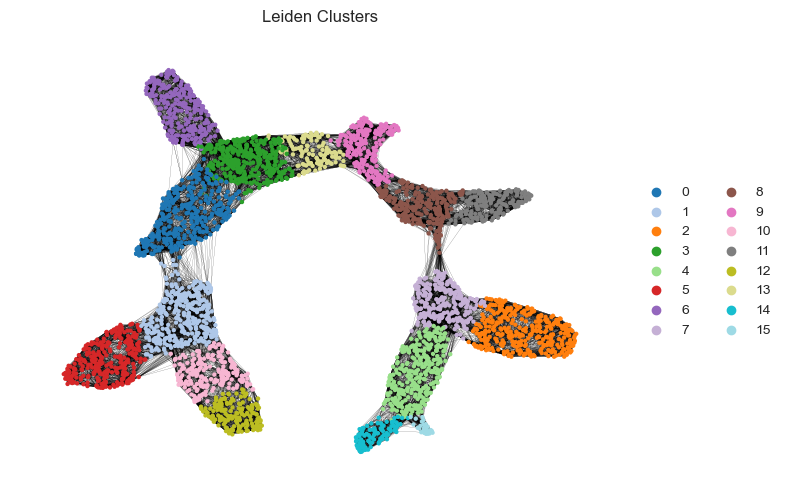

In [57]:
# Let's visualize the cell states/ leiden clusters of the cells in our FULL dataset. We will choose from this the source, and target leiden clusters for our cell transitions
sc.pl.umap(full_simulated_ad, color='leiden', title='Leiden Clusters', size=40,
            frameon=False, 
           edges=True, 
           edges_color='black')

We will choose some clusters to de-differentiation and trans-differentiate. This will need to be changed depending on the simulated data

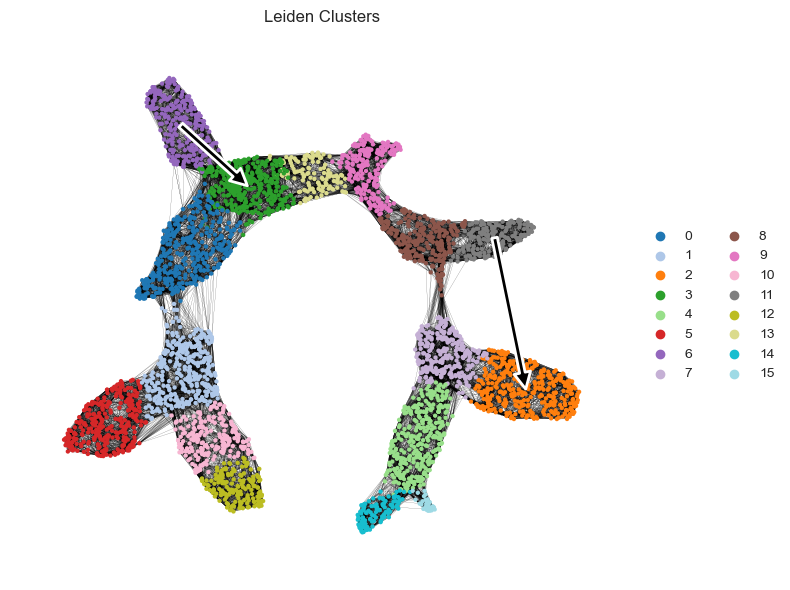

In [59]:
destination_clusters = {
    '11': {'destination': '2', 'proportion': 0.4},
    '6': {'destination': '3', 'proportion': 0.2}
}

assert set(destination_clusters.keys()) - set(ad.obs['leiden'].unique()) == set(), f"Source clusters must be in the data. Choose from {set(ad.obs['leiden'].unique())}"
# We can also visualize these changes on UMAP
plastro.plot_leiden_transitions(full_simulated_ad, destination_clusters)

Selected 69 plastic cells from leiden cluster 11 to switch to cluster 2
Selected 54 plastic cells from leiden cluster 6 to switch to cluster 3


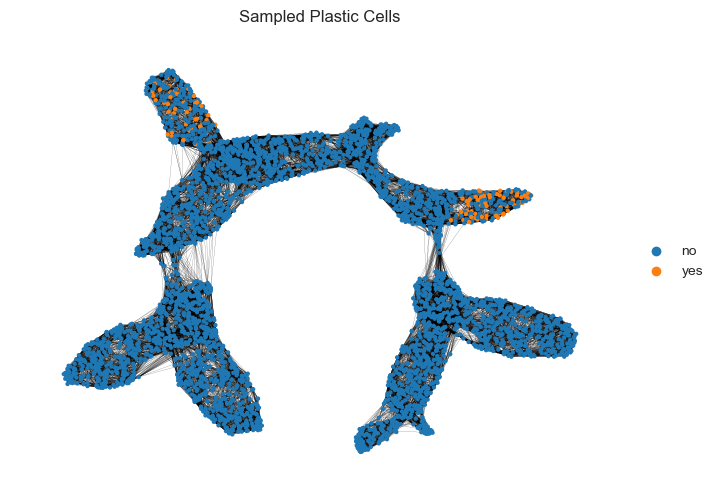

/Users/spersad/Documents/PLASTRO/plastro/plasticity.py:486: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  final_ad.obs['change_in_phenotype'] = change_distances


In [60]:
# Now we will sample the cells from the source clusters that will switch to the target clusters. 
# !WARNING: If there are too few cells in the target cluster, we will limit the proportion of cells that can switch to that cluster
plastic_cells = {}
for source, info in destination_clusters.items():
    dest = info['destination']
    prop = info['proportion']
    
    source_cells = ad.obs_names[ad.obs['leiden'] == source].to_list()
    n_plastic = int(len(source_cells) * prop)
    
    if n_plastic == 0:
        print(f"Warning: No cells selected for leiden cluster {source} with proportion {prop}. Skipping.")
        continue

    dest_cells = ad.obs_names[ad.obs['leiden'] == dest].to_list()
    if len(dest_cells) < n_plastic:
        n_plastic = len(dest_cells)
        print(f"Warning: Not enough cells in target cluster {dest}. Limiting number of plastic cells to {n_plastic}.")
    
    selected_cells = np.random.choice(source_cells, n_plastic, replace=False).tolist()
    plastic_cells[source] = {'destination': dest, 'cells': selected_cells}
    print(f"Selected {n_plastic} plastic cells from leiden cluster {source} to switch to cluster {dest}")

all_plastic_cells_leiden = sum([plastic_cells[cl]['cells'] for cl in plastic_cells], [])
full_simulated_ad.obs['Will Change Phenotype'] = ['yes' if cell in all_plastic_cells_leiden else 'no' for cell in full_simulated_ad.obs_names]
sc.pl.umap(full_simulated_ad, color=['Will Change Phenotype'], title=['Sampled Plastic Cells'], size=40,
            frameon=False, 
           edges=True, 
           edges_color='black')

plt.show()

plastic_leiden_ad = plastro.cluster_switch_plasticity(full_simulated_ad, ad, plastic_cells, column='leiden')


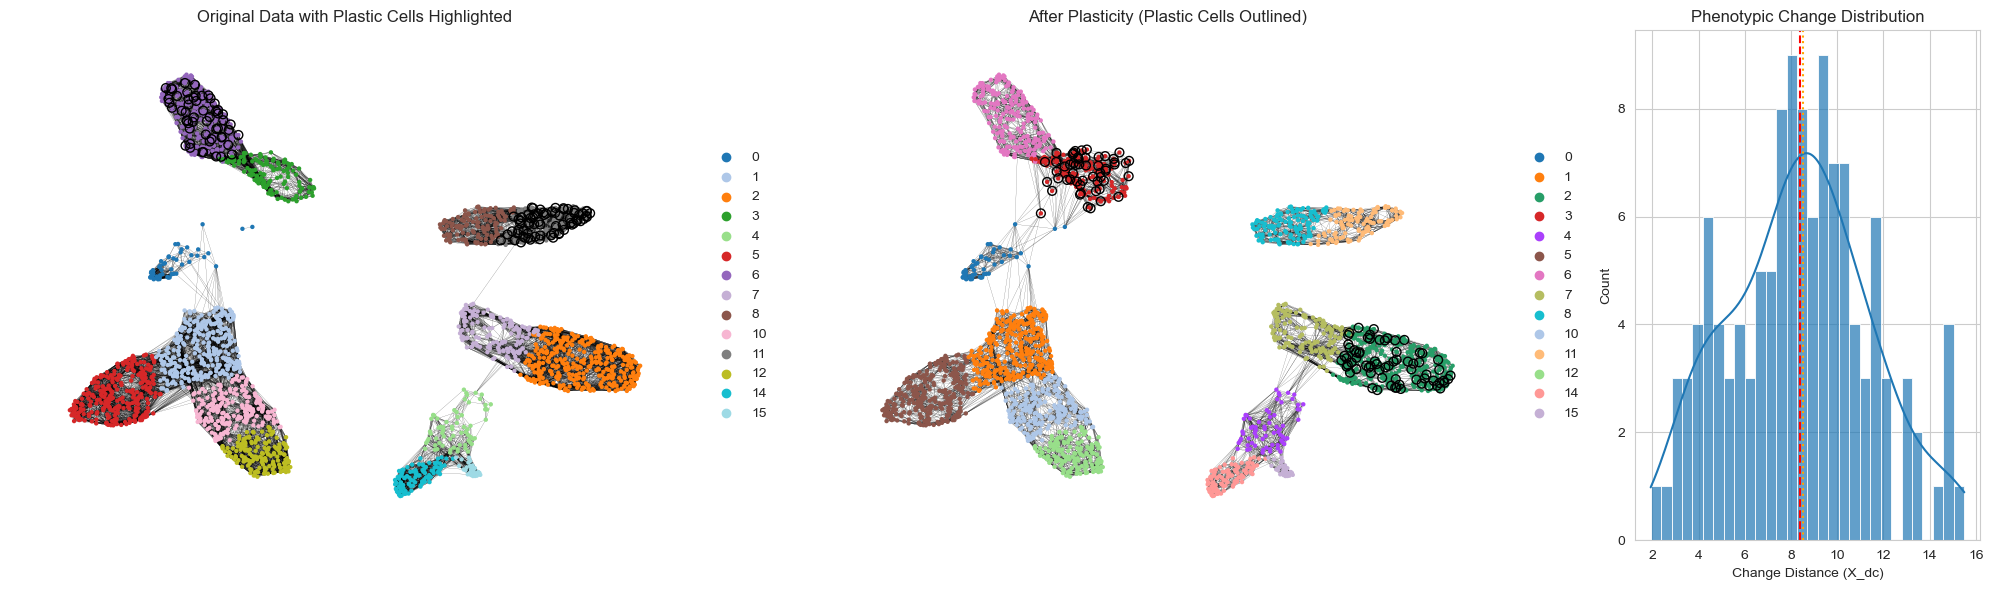

In [66]:
sc.pp.neighbors(plastic_leiden_ad)
plastro.plot_change_in_phenotype(ad, plastic_leiden_ad, all_plastic_cells_leiden, show_plots=True, save_to=os.path.join(results_dir, 'leiden_phenotype_change.png'))


## 5. Summary and Export Results

Let's summarize our plasticity simulation results and save the key outputs.

In [67]:
# Save the main annData objects
full_simulated_ad.write(os.path.join(results_dir, 'full_simulated_data.h5ad'))
ad.write(os.path.join(results_dir, 'original_data.h5ad'))
plastic_walk_ad.write(os.path.join(results_dir, 'random_walk_plasticity.h5ad'))
plastic_leiden_ad.write(os.path.join(results_dir, 'leiden_switch_plasticity.h5ad'))
print("Saved simulation results to:")
print(f"- Full simulated data: {os.path.join(results_dir, 'full_simulated_data.h5ad')}")
print(f"- Original data: {os.path.join(results_dir, 'original_data.h5ad')}")
print(f"- Random walk plasticity: {os.path.join(results_dir, 'random_walk_plasticity.h5ad')}")
print(f"- Leiden switch plasticity: {os.path.join(results_dir, 'leiden_switch_plasticity.h5ad')}")

Saved simulation results to:
- Full simulated data: plasticity_example_results/full_simulated_data.h5ad
- Original data: plasticity_example_results/original_data.h5ad
- Random walk plasticity: plasticity_example_results/random_walk_plasticity.h5ad
- Leiden switch plasticity: plasticity_example_results/leiden_switch_plasticity.h5ad


# Next Steps

Explore the `plastro_overlap_analysis` notebook to see how we can measure single-cell plasticity values for this simulated data.